In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nansat import Nansat, Domain
from boreali import Boreali, lm
import csv

# %matplotlib inline
%matplotlib nbagg

In [2]:
# Test img_oct path: ./data/A2014301181500.L2_LAC_OC.x.nc
# Test img_may path: ./data/A2014301181500.L2_LAC_OC.x.nc

# Bathymetry file path: ./data/michigan_lld.grd
# source: https://www.ngdc.noaa.gov/mgg/greatlakes/michigan.html
# units: meters

img_oct = Nansat('./data/A2014301181500.L2_LAC_OC.x.nc')
img_may = Nansat('./data/A2014121184000.L2_LAC_OC.x.nc')

bathymetry = Nansat('./data/michigan_lld.grd')

dom = Domain('+proj=latlong +datum=WGS84 +ellps=WGS84 +no_defs', '-lle -86.3 44.6 -85.2 45.3 -ts 122 78')
# Each point is ~ 0.4 km (300x200)
# Each point is ~ 1.0 km (122x78)

img_oct.reproject(dom)
img_may.reproject(dom)

bathymetry.reproject(dom)

=>michigan.grd<=


In [3]:
# preparing of bottom field
h = bathymetry[1]
# all points there h >= 0 will marked as np.nan
h = np.where(h >= 0, np.nan, np.float32(h) * -1)
# the mask of land 
h_mask = np.where(np.isfinite(h), np.nan, np.array(1))

# the mask which shows 10 meters depth zone
h_10m = np.where(h <= 10, np.array(1), np.nan)

/home/artemm/Programs/Miniconda/miniconda2/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less_equal


In [4]:
def show_it(obj, name, color='jet', limits=None, z10='off', size=(9, 6), coord_grid='off'):
    plt.figure(figsize=size)
    plt.imshow(obj, clim=limits, cmap=color)
    plt.colorbar()
    plt.title(name, y=1.08, fontsize=16)
    plt.tick_params(labelsize=14)

    if coord_grid == 'on':
        y = np.arange(0.0, 79.0, 79.0 / 7)
        y_labels = np.arange(45.3, 44.5, -0.1)
        x = np.arange(0.0, 123.0, 123.0 / 11)
        x_labels = np.arange(86.3, 85.2, -0.1)
        plt.yticks(y, y_labels)
        plt.xticks(x, x_labels)

    # black field is area which depth less than 10 meters
    if z10 == 'on': plt.imshow(h_10m, cmap='gray')
    plt.imshow(h_mask, cmap='Dark2')
    plt.grid(color='black')

<IPython.core.display.Javascript object>


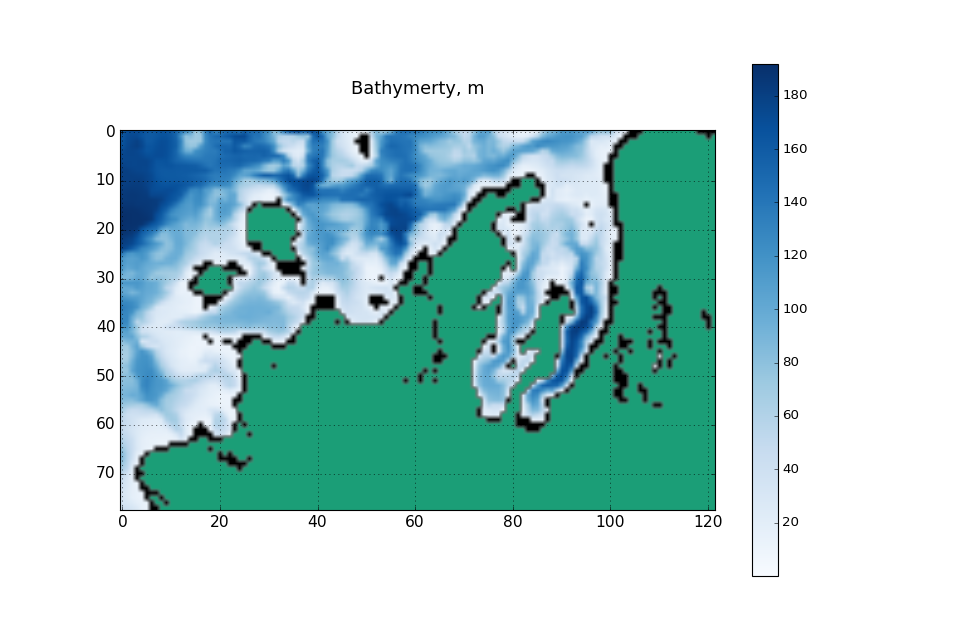

In [5]:
# plotting of bottom field
# blue is water, green is land, black is zone of less than 10 meters depth
show_it(h, 'Bathymerty, m', color='Blues', z10='on', size=(12,8))

In [6]:
# List of sets of bands  which were used to boreali processing:

wavelens_base = [412, 443, 469, 488, 531, 547, 555, 645, 667, 678]   # All MODIS channels
wavelens_blue_off = [443, 469, 488, 531, 547, 555, 645, 667, 678]    # Without 412 nm
wavelens_1x1km_bands = [412, 443, 488, 531, 645, 678]   # Only 1x1 km spatial resolution bands
wavelens_red_off = [412, 443, 469, 488, 531, 547, 555, 645, 667]    # Without 678 nm
wavelens_blueandred_off = [443, 469, 488, 531, 547, 555, 645, 667]   # Without 412 nm and 678 nm
wavelens_red_off_full = [412, 443, 469, 488, 531, 547, 555]

In [7]:
def boreali_processing(n_img, wavelens, h, bottom_type=0, osw_mod='on'):
    """
    :param n_img: Nansat img
    :param wavelen: nupy array (vector) of wave lenghts
    :param h: numpy array of bottom deph was got from michigan_lld.grd
    :param osw_mod: Need i to use OSW ?  
    :return: numpy array custom_n which contain Rrs, Rrsw and CPA data
    """
    cpa_limits = [0.01, 3, 
                  0.01, 1, 
                  0.01, 1, 10]
    
    b = Boreali('michigan', wavelens)
    theta = np.zeros_like(n_img[2])
    custom_n = Nansat(domain=n_img)
    band_rrs_numbers = list(map(lambda x: n_img._get_band_number('Rrs_' + str(x)), wavelens)) 
    
    for index in range(0, len(wavelens)):
        rrsw = n_img[band_rrs_numbers[index]] / (0.52 + 1.7 * n_img[band_rrs_numbers[index]])   
        custom_n.add_band(rrsw, parameters={'name': 'Rrsw_' + str(wavelens[index]),  
                                            'units': 'sr-1',
                                            'wavelength': wavelens[index]})
        
        # If we want to use OSW mod, we will need to add Rrs data in custom_n obj
        if osw_mod == 'on':
            custom_n.add_band(n_img[band_rrs_numbers[index]], parameters={'name': 'Rrs_' + str(wavelens[index]),
                                                                          'units': 'sr-1',
                                                                          'wavelength': wavelens[index]})
    # Creating of the mask
    # All pixels marked as -0.015534 in img will marked as 0.0 in the mask
    mask = np.where(n_img[2] != np.float(-0.015534), np.array(64.0), np.array(0.0)) 
    # Validation of mask according to bathymetry data.
    # If in the bathymetry pixel was marked as np.nan, in mask he will marked as 0.0
    # else nothing
    mask = np.where(np.isnan(h), np.array(0.), mask)
    # Adding of mask into custom_n obj
    custom_n.add_band(mask, parameters={'name' : 'mask'})
    
    # h is trigger for OWS processing mod. 
    # If want to star OSW we will need to add h to Boreali.process
    # else marked it as None
    if osw_mod == 'on': 
        depth = h
    else: 
        depth = None
    
    cpa = b.process(custom_n, cpa_limits,  mask=custom_n['mask'], depth=depth, theta=theta, threads=4)

    custom_n.add_band(array=cpa[0], parameters={'name': 'chl',
                                                'long_name': 'Chlorophyl-a',
                                                'units': 'mg m-3'})
    custom_n.add_band(array=cpa[1], parameters={'name': 'tsm',
                                                'long_name': 'Total suspended matter',
                                                'units': 'g m-3'})
    custom_n.add_band(array=cpa[2], parameters={'name': 'doc',
                                                        'long_name': 'Dissolved organic carbon',
                                                'units': 'gC m-3'})
    custom_n.add_band(array=cpa[3], parameters={'name': 'mse',
                                                'long_name': 'Root Mean Square Error',
                                                'units': 'sr-1'})
    custom_n.add_band(array=cpa[4], parameters={'name': 'mask',
                                                'long_name': 'L2 Boreali mask',
                                                'units': '1'})
    
    #   custom_n.export(final_path + obj.split('/')[-1] + 'cpa_OSW.nc')
    return custom_n

wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrs_
(10, 78, 122)
Pixels x bands to process:  (3360, 10)
launch shallow
launch shallow
launch shallow
launch shallow
spent:  6.91325211525
wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrsw_
(10, 78, 122)
Pixels x bands to process:  (3360, 10)
launch deep
launch deep
launch deep
launch deep
spent:  4.21353411674


<IPython.core.display.Javascript object>


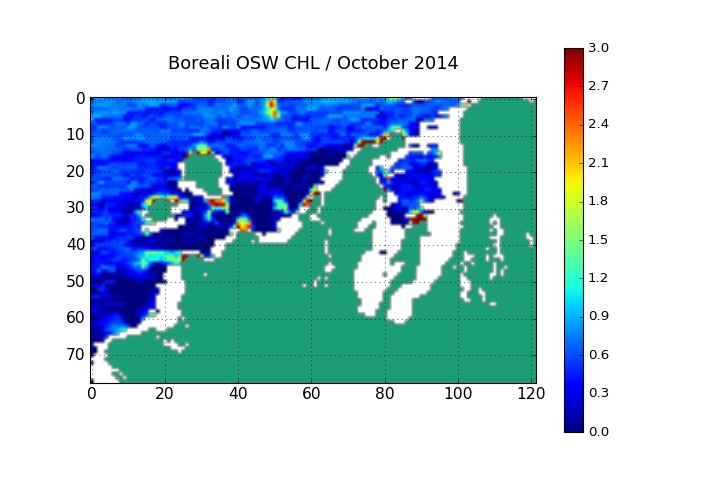

<IPython.core.display.Javascript object>


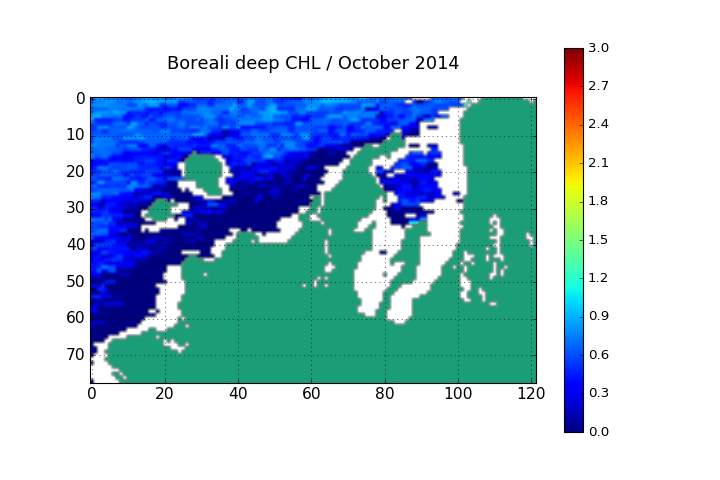

In [8]:
test_oct_1 = boreali_processing(img_oct, wavelens_base, h, osw_mod='on') # Boreali-OSW processing
test_oct_2 = boreali_processing(img_oct, wavelens_base, h, osw_mod='off') # Boreali-bace processing 

show_it(test_oct_1['chl'], name='Boreali OSW CHL / October 2014', limits=[0.,3.0])
show_it(test_oct_2['chl'], name='Boreali deep CHL / October 2014', limits=[0.,3.0])

wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrs_
(10, 78, 122)
Pixels x bands to process:  (1122, 10)
launch shallow
launch shallow
launch shallow
launch shallow
spent:  2.09900689125
wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrsw_
(10, 78, 122)
Pixels x bands to process:  (1122, 10)
launch deep
launch deep
launch deep
launch deep
spent:  1.24973297119


<IPython.core.display.Javascript object>


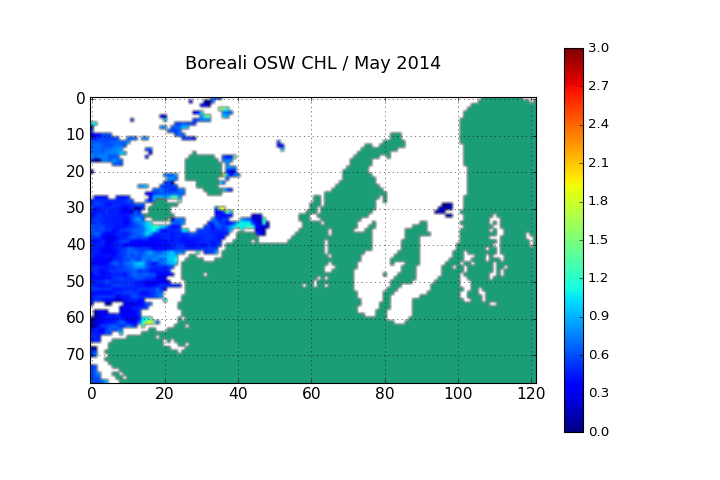

<IPython.core.display.Javascript object>


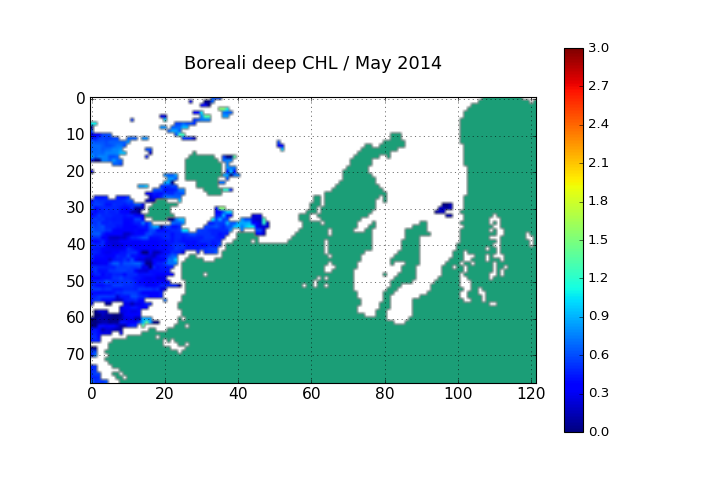

In [9]:
test_may_1 = boreali_processing(img_may, wavelens_base, h, osw_mod='on') # Boreali-OSW processing
test_may_2 = boreali_processing(img_may, wavelens_base, h, osw_mod='off') # Boreali-bace processing 

show_it(test_may_1['chl'], name='Boreali OSW CHL / May 2014', limits=[0.,3.0])
show_it(test_may_2['chl'], name='Boreali deep CHL / May 2014', limits=[0.,3.0])

In [16]:
def get_r(obj, coords, r_type, wavelens):
    y, x = coords
    band_numbers = list(map(lambda x: obj._get_band_number(r_type + str(x)), wavelens))
    r_list = [obj[band][y][x] for band in band_numbers]
    return r_list


def plot_r(obj, wavelens, coords, r_type='Rrs_', size=(9, 6), title=None):
    y, x = coords
    r_list = get_r(obj, coords, r_type, wavelens)
    num_bands = range(0, len(r_list))

    plt.figure(figsize=size)
    plt.title('%s / %s / Point: (x: %d, y:%d) / Depth: %5.2f' % (title,r_type, x, y, h[y, x]))
    plt.tick_params(labelsize=14)
    plt.plot(num_bands, r_list)
    plt.xticks(num_bands, wavelens)
    plt.xlabel('wavelength, nm', fontsize=14)
    plt.ylabel('%s, sr^-1' % (r_type), fontsize=14)
    plt.grid(color='black')
    # plt.ylim([0, 0.04])

In [11]:
def find_valid_points(coord_list):
    points = [] 
    for i in range(0, len(coord_list)):
        y,x = coord_list[i]
        if True not in np.isnan(h[y-1:y+2, x-1:x+2]) and y not in (0, 78) and x not in (0, 122):
            points.append(coord_list[i])
    return points

def negative_spectrum_filter(obj, pixels):
    positive_px = []
    for pixel in pixels:
        if obj['chl'][pixel[0], pixel[1]] != np.nan:
            flag = 1
            r = get_r(test1, pixel, 'Rrs_', wavelens_base)
            for i in r:
                if i < 0:
                    flag = 0
            if flag == 1: positive_px.append(pixel)

# We get a list of coordinates (tuple of (y,x) indexes of px) 
# of points which shallower then 10 m
coords = zip(*np.where(h_10m == 1)) 
# Checking that the pixel situated farther than 1 px (1 km) from the coast?
pixels = find_valid_points(coords)

In [12]:
def boreali_lm(obj, wavelens, h, coords, bottom_type=0, show='on', title=None):
    y, x = coords
    b = Boreali('michigan', wavelens)
    model = b.get_homodel()
    theta = 0
    albedoType = bottom_type
    depth = h[y,x]
    albedo = b.get_albedo([albedoType])[0]

    cpa_limits = [0.01, 3,
                  0.01, 1,
                  0.01, 1, 10]

    r = get_r(obj, (y, x), 'Rrsw_', wavelens)    #
    c_deep = lm.get_c_deep(cpa_limits, model, [r], [theta], 4)[1]
    c_osw = lm.get_c_shal(cpa_limits, model, [r], [theta], [depth], [albedo], 4)[1]

    if show == 'on':
        print title
        print 'BOREALI DEEP: chl=%5.2f, tsm=%5.2f, doc=%5.2f, rmse=%5.2f' % tuple(c_deep)
        print 'BOREALI OSW: chl=%5.2f, tsm=%5.2f, doc=%5.2f, rmse=%5.2f' % tuple(c_osw)
        plot_r(obj, wavelens=wavelens, coords=(y, x), size=(10, 4), title='title')
    else:
        return c_osw, c_deep, depth

May 2014
BOREALI DEEP: chl= 0.32, tsm= 0.17, doc= 0.06, rmse= 0.00
BOREALI OSW: chl= 0.27, tsm= 0.23, doc= 0.04, rmse= 0.00


<IPython.core.display.Javascript object>


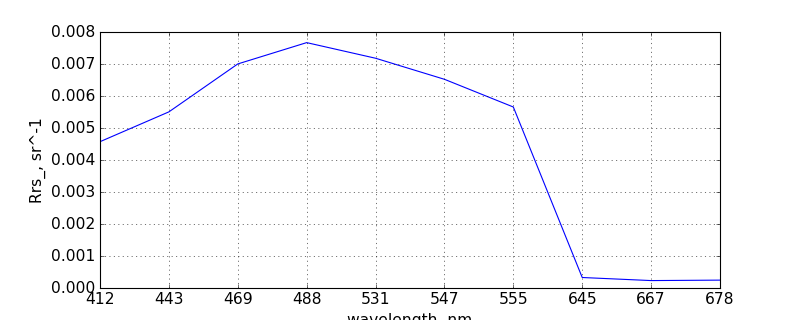

October 2014
BOREALI DEEP: chl= 0.01, tsm= 0.09, doc= 0.09, rmse= 0.00
BOREALI OSW: chl= 0.56, tsm= 0.04, doc= 0.05, rmse= 0.00


<IPython.core.display.Javascript object>


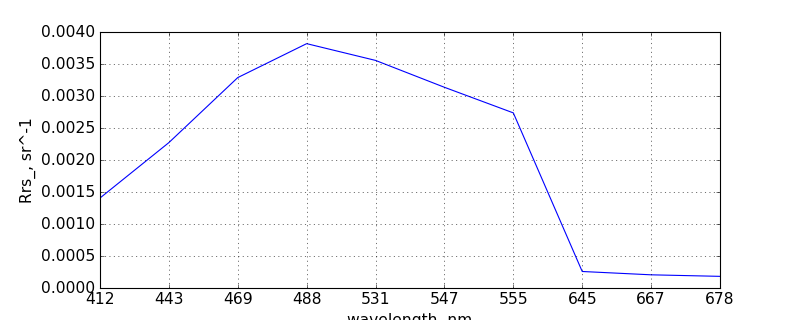

In [13]:
px = (43, 18)
boreali_lm(test_may_1, wavelens_base, h, px, bottom_type=0, title='May 2014')
boreali_lm(test_oct_1, wavelens_base, h, px, bottom_type=0, title='October 2014')

May 2014
BOREALI DEEP: chl= 0.58, tsm= 0.10, doc= 0.04, rmse= 0.00
BOREALI OSW: chl= 0.73, tsm= 0.12, doc= 0.02, rmse= 0.00


<IPython.core.display.Javascript object>


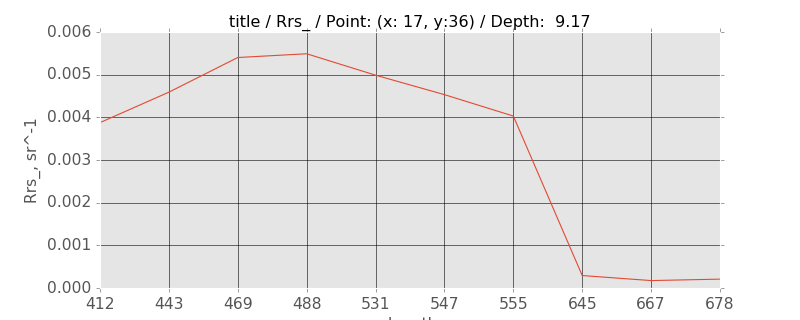

October 2014
BOREALI DEEP: chl= 0.01, tsm= 0.01, doc= 1.00, rmse= 0.10
BOREALI OSW: chl= 0.51, tsm= 0.01, doc= 1.00, rmse= 0.10


<IPython.core.display.Javascript object>


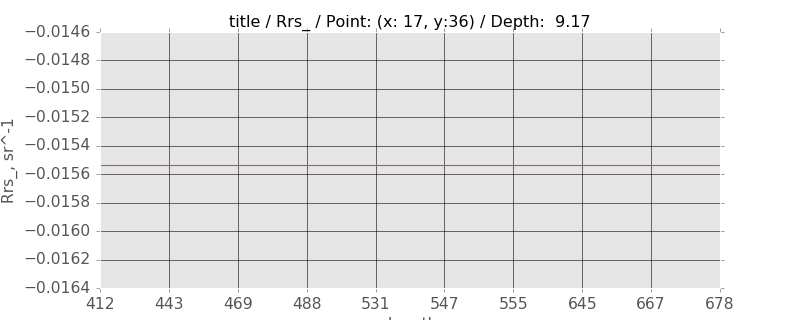

In [56]:
px = (36, 17)
boreali_lm(test_may_1, wavelens_base, h, px, bottom_type=0, title='May 2014')
boreali_lm(test_oct_1, wavelens_base, h, px, bottom_type=0, title='October 2014')

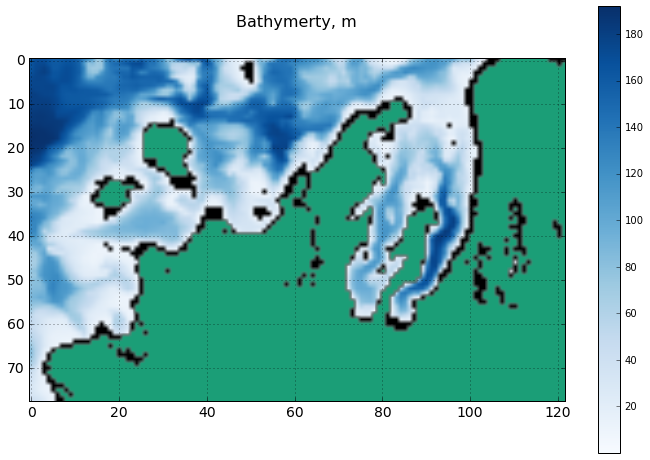

In [16]:
show_it(h, 'Bathymerty, m', color='Blues', z10='on', size=(12,8))

wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrs_
(10, 78, 122)
Pixels x bands to process:  (1122, 10)
launch shallow
launch shallow
launch shallow
launch shallow
spent:  2.17660498619
wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrsw_
(10, 78, 122)
Pixels x bands to process:  (1122, 10)
launch deep
launch deep
launch deep
launch deep
spent:  1.23600697517


<IPython.core.display.Javascript object>


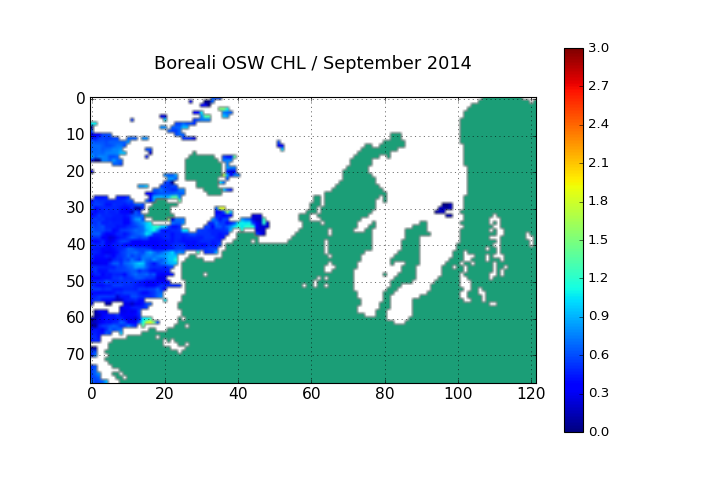

<IPython.core.display.Javascript object>


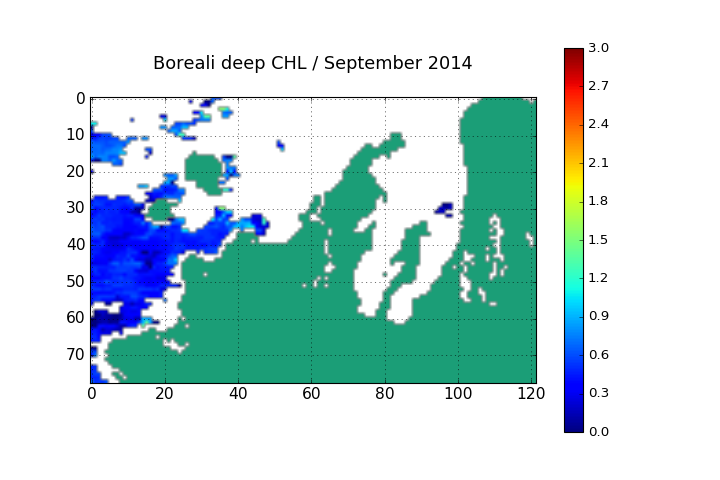

In [14]:
lol = Nansat('/home/artemm/Documents/PythonProjects/work/data/A2014259191500.L2_LAC_OC.x.nc')
lol.reproject(dom)

test1 = boreali_processing(img_may, wavelens_base, h, osw_mod='on') # Boreali-OSW processing
test2 = boreali_processing(img_may, wavelens_base, h, osw_mod='off') # Boreali-bace processing 

show_it(test1['chl'], name='Boreali OSW CHL / September 2014', limits=[0.,3.0])
show_it(test2['chl'], name='Boreali deep CHL / September 2014', limits=[0.,3.0])

May 2014 Sand
BOREALI DEEP: chl= 0.41, tsm= 0.07, doc= 0.04, rmse= 0.00
BOREALI OSW: chl= 0.41, tsm= 0.13, doc= 0.03, rmse= 0.00


<IPython.core.display.Javascript object>


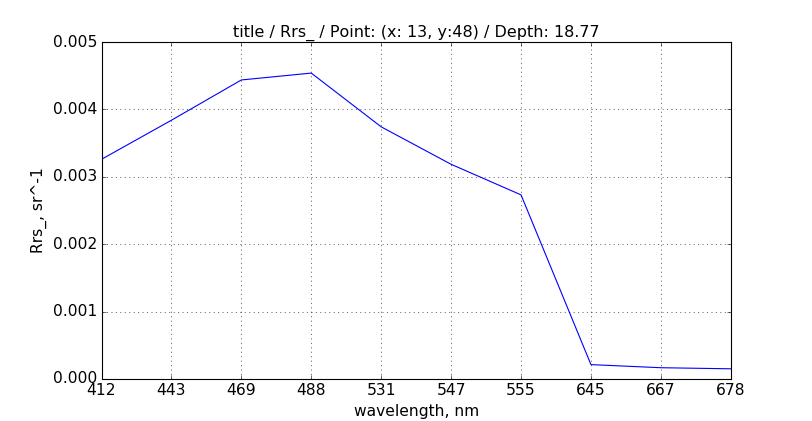

May 2014 Chladophora
BOREALI DEEP: chl= 0.41, tsm= 0.07, doc= 0.04, rmse= 0.00
BOREALI OSW: chl= 0.01, tsm= 0.08, doc= 0.03, rmse= 0.00


<IPython.core.display.Javascript object>


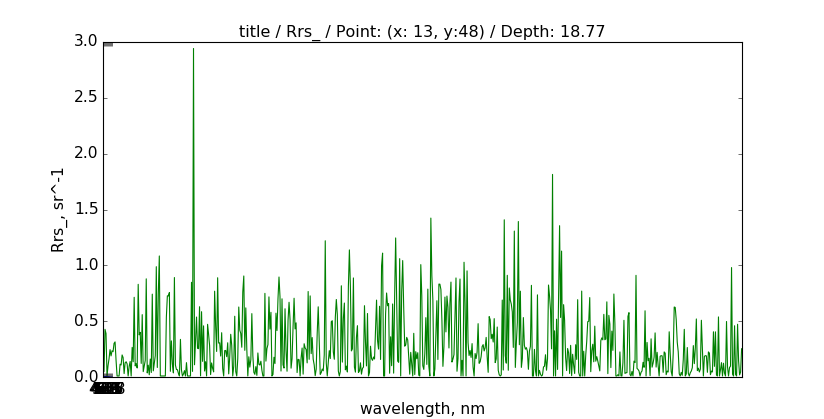

In [17]:
px1 = (48, 13)
boreali_lm(test1, wavelens_base, h, px1, bottom_type=0, title='May 2014 Sand')
px1 = (48, 13)
boreali_lm(test1, wavelens_base, h, px1, bottom_type=6, title='May 2014 Chladophora')

/home/artemm/Programs/Miniconda/miniconda2/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]


<IPython.core.display.Javascript object>


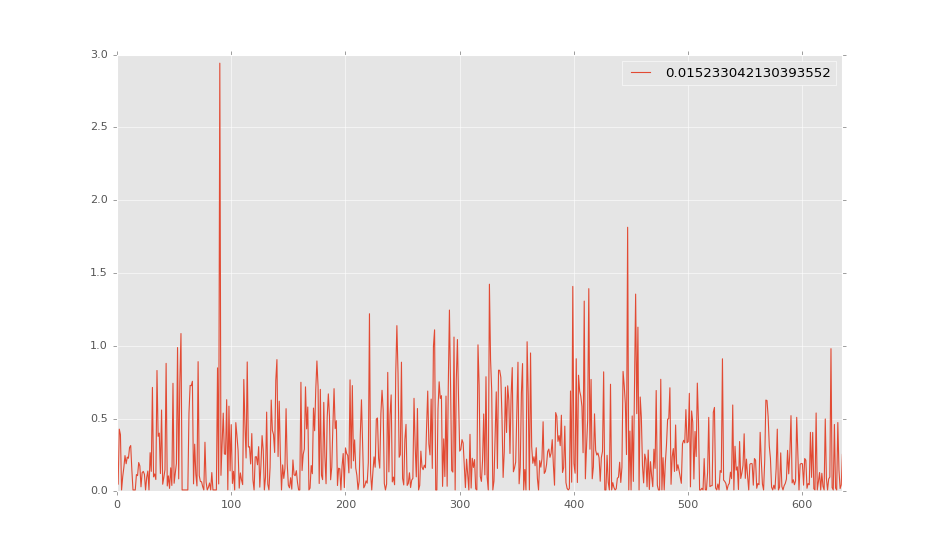

In [54]:
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')

data = pd.read_csv('/home/artemm/Desktop/1pointdata.csv')
data.head()


data.icol([3]).plot()

In [52]:
from scipy import stats

lol = np.array(data.icol(3))
lol1 = np.arange(1, len(lol)+1)
print len(lol), len(lol1)
gradient, intercept, r_value, p_value, std_err = stats.linregress(lol1,lol)

636 636


/home/artemm/Programs/Miniconda/miniconda2/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]
  app.launch_new_instance()


In [53]:
gradient, intercept, r_value, p_value, std_err

(-9.7574032615402008e-05,
 0.31888069743441738,
 -0.057472141716054387,
 0.14769038429397188,
 6.7315303624365818e-05)